In [1]:
import os
import glob

# h5py can read hdf5 dataset
import h5py

# delete bad data files
from send2trash import send2trash

# fastmri has some k-space undersampling functions we can use
# git clone https://github.com/facebookresearch/fastMRI.git
# go to the fastmri directory
# pip install -e.
import fastmri

# We will use this functions to generate masks
from fastmri.data.subsample import RandomMaskFunc, EquispacedMaskFunc

# sigpy is apparently a good MRI viewing tool
# pip install sigpy
import sigpy as sp
import sigpy.plot as pl

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib

%matplotlib notebook

In [2]:
# define constants
DATASET = 'singlecoil_train'
AXES = {
        'singlecoil_train' : (1, 2),
        'multicoil_train' : (2, 3),
       }
PATH = os.path.join(os.getcwd(), DATASET)
mri_paths = glob.glob(os.path.join(PATH, '*1.h5'))

In [14]:
# this block gets Dataset object with imaginary and real separated
def _get_kspace_and_reconstruction_rss(filename):
    """
    @params filename: full path to .h5 mri file
    @return kspace data of that particular file
    """
    try:
        with h5py.File(filename, 'r') as hr:
            return hr['kspace'][:], hr['reconstruction_rss'][:]
    except:
        print(f'Error could not open {filename}')

def _get_kspace_undersampled(kspace, center_fractions = [0.04], accelerations = [4]):
    """
    @params kspace: from _get_kspace_and_reconstruction_rss(filename)
    @params center_fractions: for undersampling, 
        N*center_fraction columns in center corresponding to low-frequencies
    @params accelerations: how much mri acquisition is sped up
    @return undersampled k-space
    """
    mask_func = RandomMaskFunc(
        center_fractions = center_fractions, 
        accelerations = accelerations
    )
    mask = np.array(mask_func(kspace.shape))
    return kspace * mask



def _get_mri_im_separated(
#     kspace, 
    reconstruction_rss,
    kspace_undersampled, 
    DATASET
):
    """
    separates imaginary from real values
    # @params kspace: from _get_kspace_and_reconstruction_rss(filename)
    @params reconstruction_rss: reconstructed MR image of fully sampled kspace, provided
    @params kspace_undersampled: mask-undersampled k-space from _get_kspace_undersampled
    @params DATASET: i.e. 'singlecoil_challenge' or 'multicoil_challenge'
    @return (undersampled mri image, fully sampled mri image (i.e. label for GAN))
    """
    undersampled_im = sp.ifft(kspace_undersampled, axes=AXES[DATASET])
#     fullysampled_im = sp.ifft(kspace, axes=AXES[DATASET])
    
    #crop to make sure images are all the same size
    undersampled_crop = sp.resize(
        undersampled_im,
        [1, 32, 256, 256]
#         [1, 30, 320, 320] # [batch size, height, length, width]
    )
    
    undersampled_crop_real = tf.math.real(undersampled_crop)
    undersampled_crop_imag = tf.math.imag(undersampled_crop)
    
    undersampled_crop = np.stack(
        (undersampled_crop_real, undersampled_crop_imag),
        axis = 4,
    )
    
    
    fullysampled_crop = sp.resize(
        reconstruction_rss,
        [1, 32, 256, 256]
#         [1, 30, 320, 320]
    )
    
    
    return (
        undersampled_crop,
        fullysampled_crop,
    )
    



def get_datum_from_single_file_separated(filename, DATASET):
    """
    user-facing function for tf Dataset object
    @params filename: full path to .h5 mri file
    @params DATASET: i.e. 'singlecoil_challenge' or 'multicoil_challenge'
    @return (undersampled mri image, fully sampled mri image (i.e. label for GAN))
    """
    kspace, reconstruction_rss = _get_kspace_and_reconstruction_rss(filename)
    kspace_undersampled = _get_kspace_undersampled(kspace)
    return _get_mri_im_separated(
        reconstruction_rss,
        kspace_undersampled,
        DATASET,
    )




def get_data_from_files_separated(filenames, DATASET):  
    """
    user-facing function for tf Dataset object
    @params filenames: list of full paths to .h5 mri files
    @params DATASET: i.e. 'singlecoil_train' or 'multicoil_train'
    @return ndarray of 
        (undersampled mri image, fully sampled mri image (i.e. label for GAN))
    """
    undersampled_images = np.ones((1, 32, 256, 256, 2)) #[bn, h, l, w, c]
    fullysampled_images = np.ones((1, 32, 256, 256))
#     undersampled_images = np.ones((1, 30, 320, 320, 2)) #[bn, h, l, w, c]
#     fullysampled_images = np.ones((1, 30, 320, 320))
    for mri_path in filenames:
        try:
            # undersampled_crop has real and imag components
            undersampled_crop, fullysampled_crop = get_datum_from_single_file_separated(
                mri_path, DATASET
            )
               

            undersampled_images = np.vstack(
                (undersampled_images, undersampled_crop)
            )
            
            
            fullysampled_images = np.vstack(
                (fullysampled_images, fullysampled_crop)
            )
            
#             print (f'undersampled image shape: {undersampled_crop.shape}')           
#             print (f'undersampled images running total shape: {undersampled_images.shape}')
#             print (f'fully sampled images running total shape {fullysampled_images.shape}')
#             print ()
            
            
        except:
            print(f'could not open file {mri_path}')
#             send2trash(mri_path)
            print(f'sent file {mri_path} to trash')
    
    # reshape with extra one at the end for channel
    fullysampled_images = fullysampled_images.reshape(
        (-1, 32, 256, 256, 1)
    )


    return undersampled_images[1:], fullysampled_images[1:]

#

In [ ]:
under_sampled_separated, fully_sampled_separated = get_data_from_files_separated(mri_paths, DATASET)
ds_separated = tf.data.Dataset.from_tensor_slices((under_sampled_separated, fully_sampled_separated))
ds_separated = ds_separated.shuffle(150, seed = 123, reshuffle_each_iteration = True)

<IPython.core.display.Javascript object>


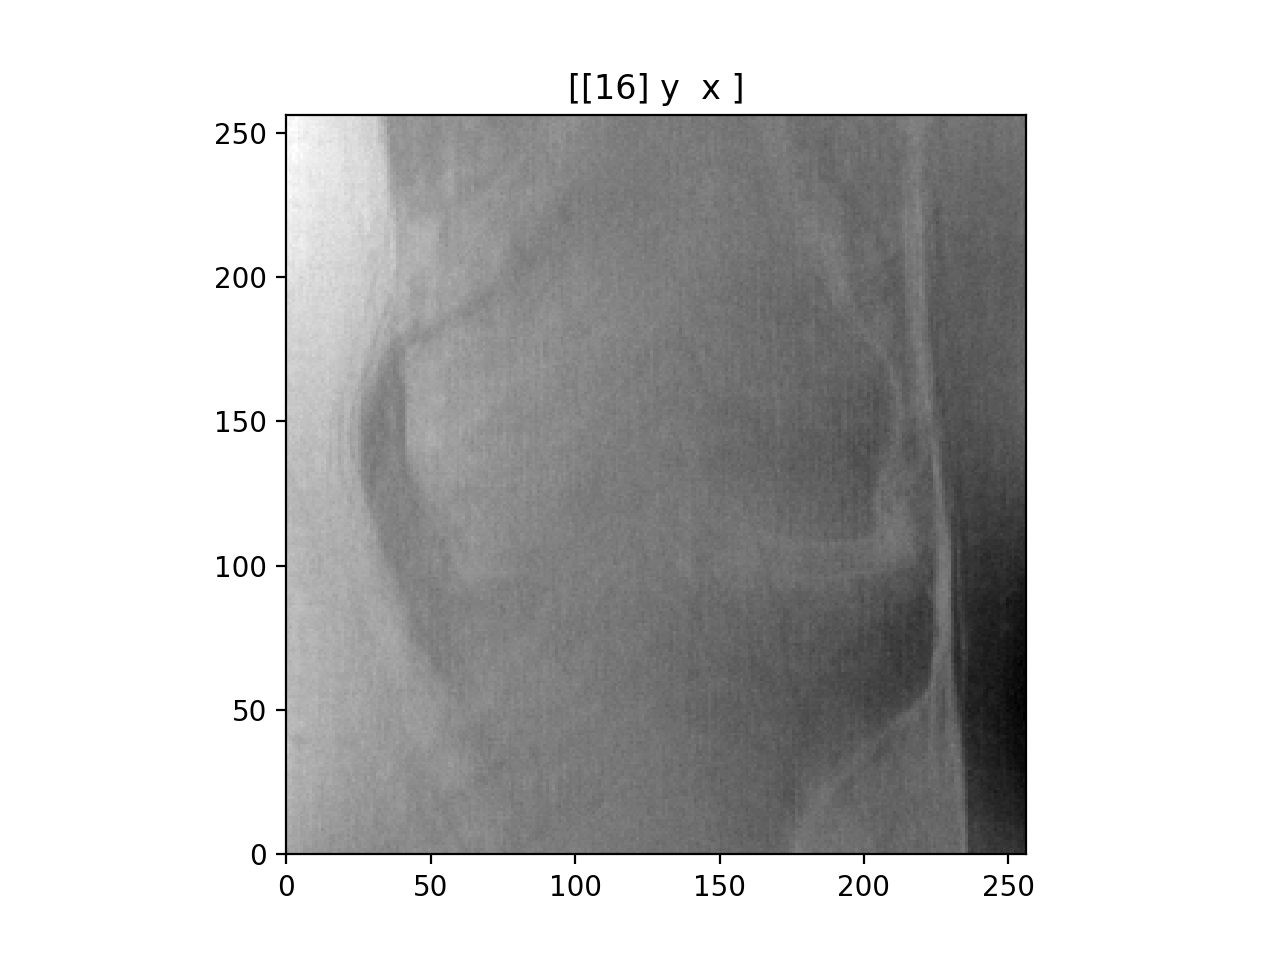

<IPython.core.display.Javascript object>


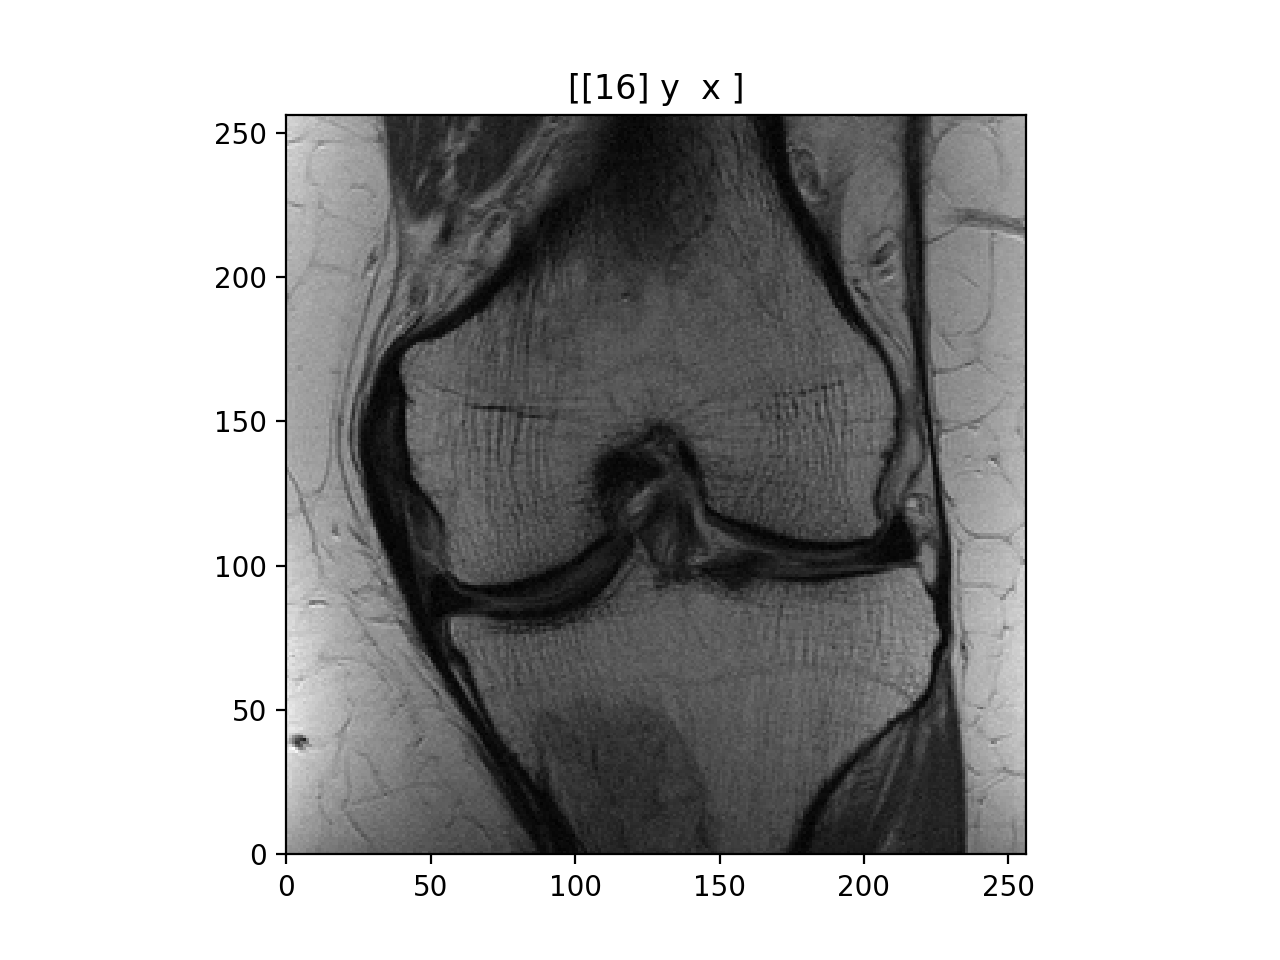

<IPython.core.display.Javascript object>


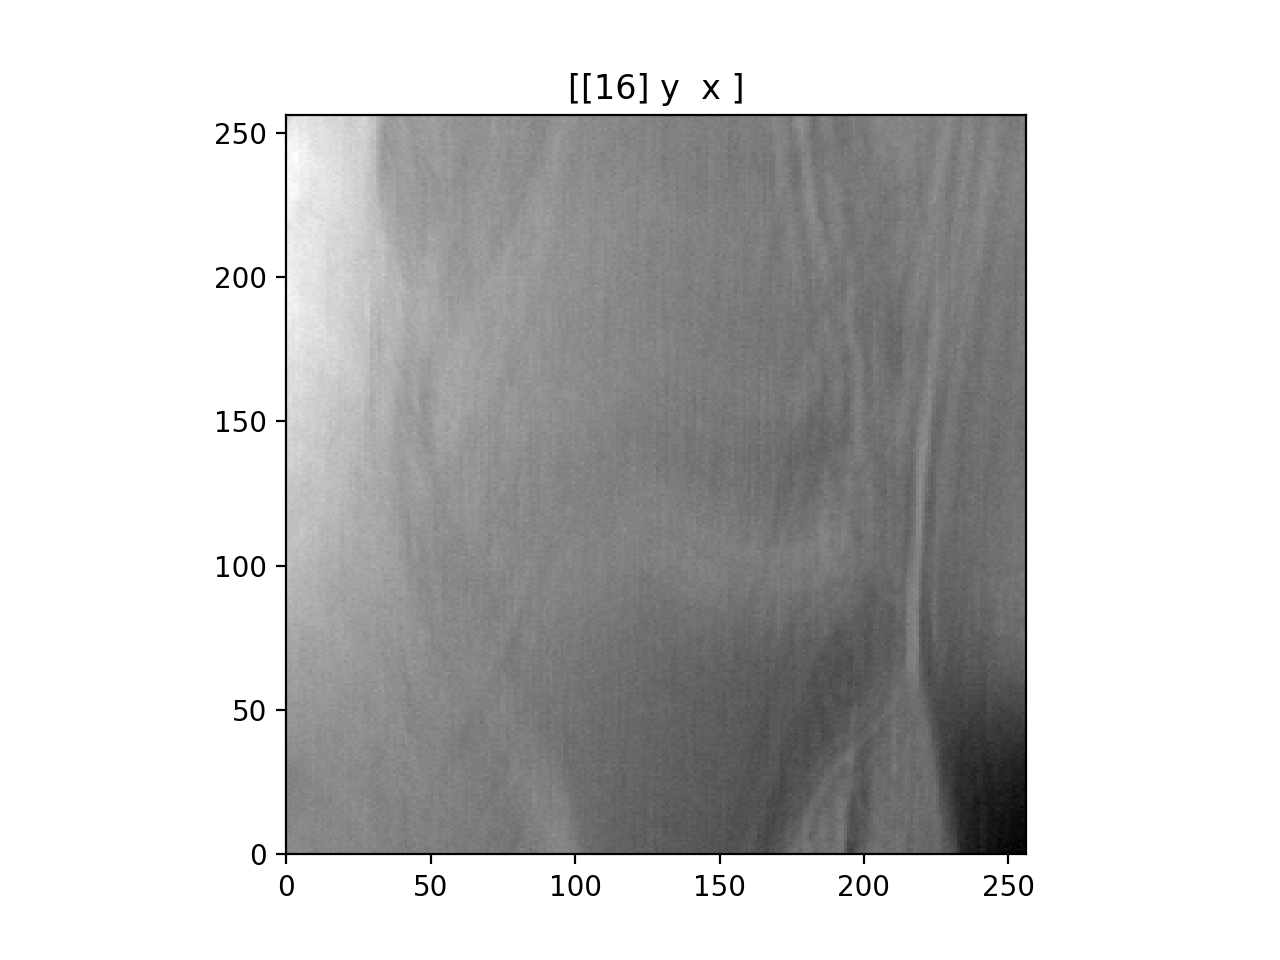

<IPython.core.display.Javascript object>


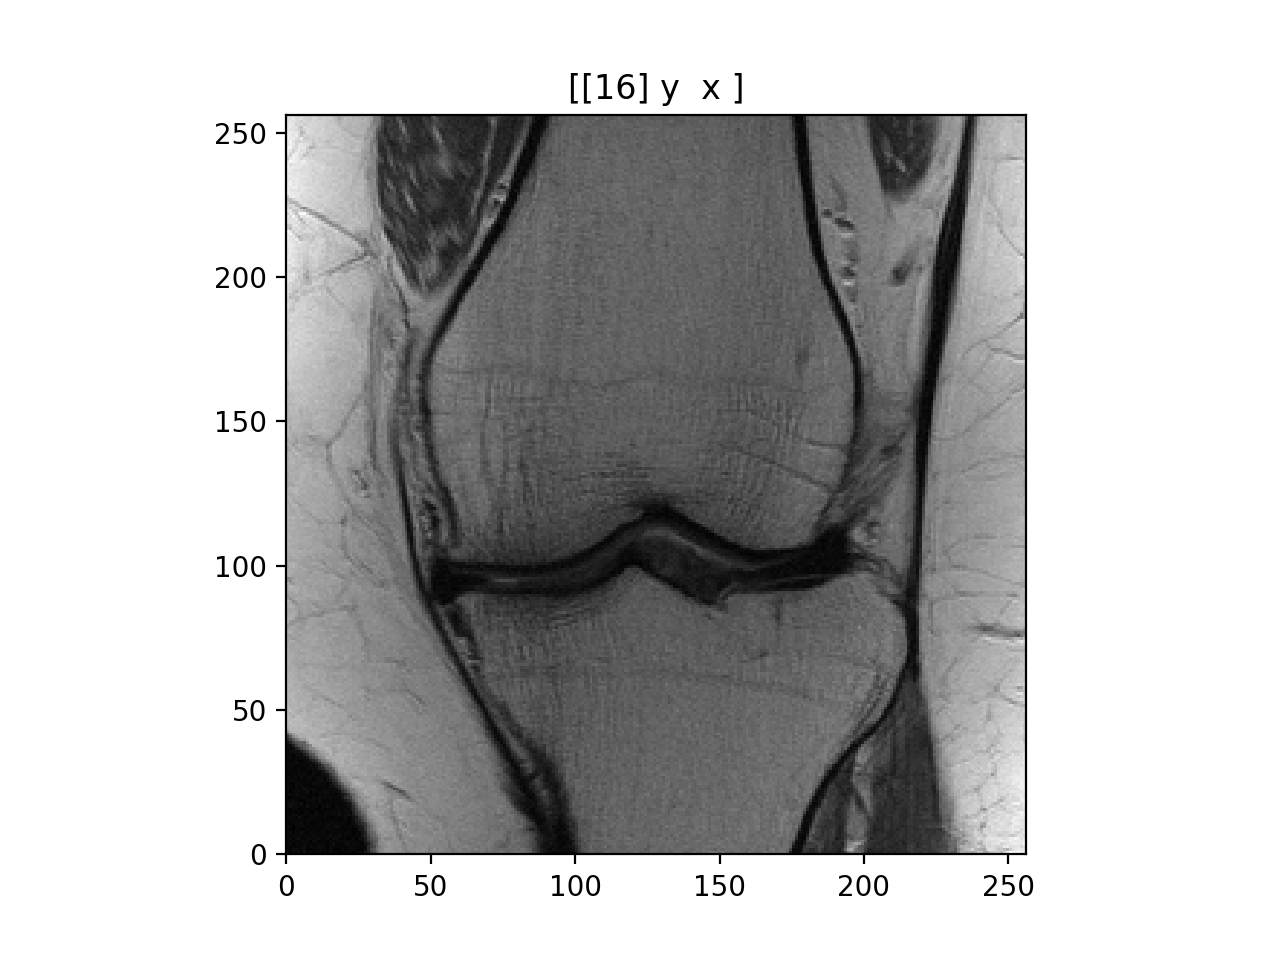

<IPython.core.display.Javascript object>


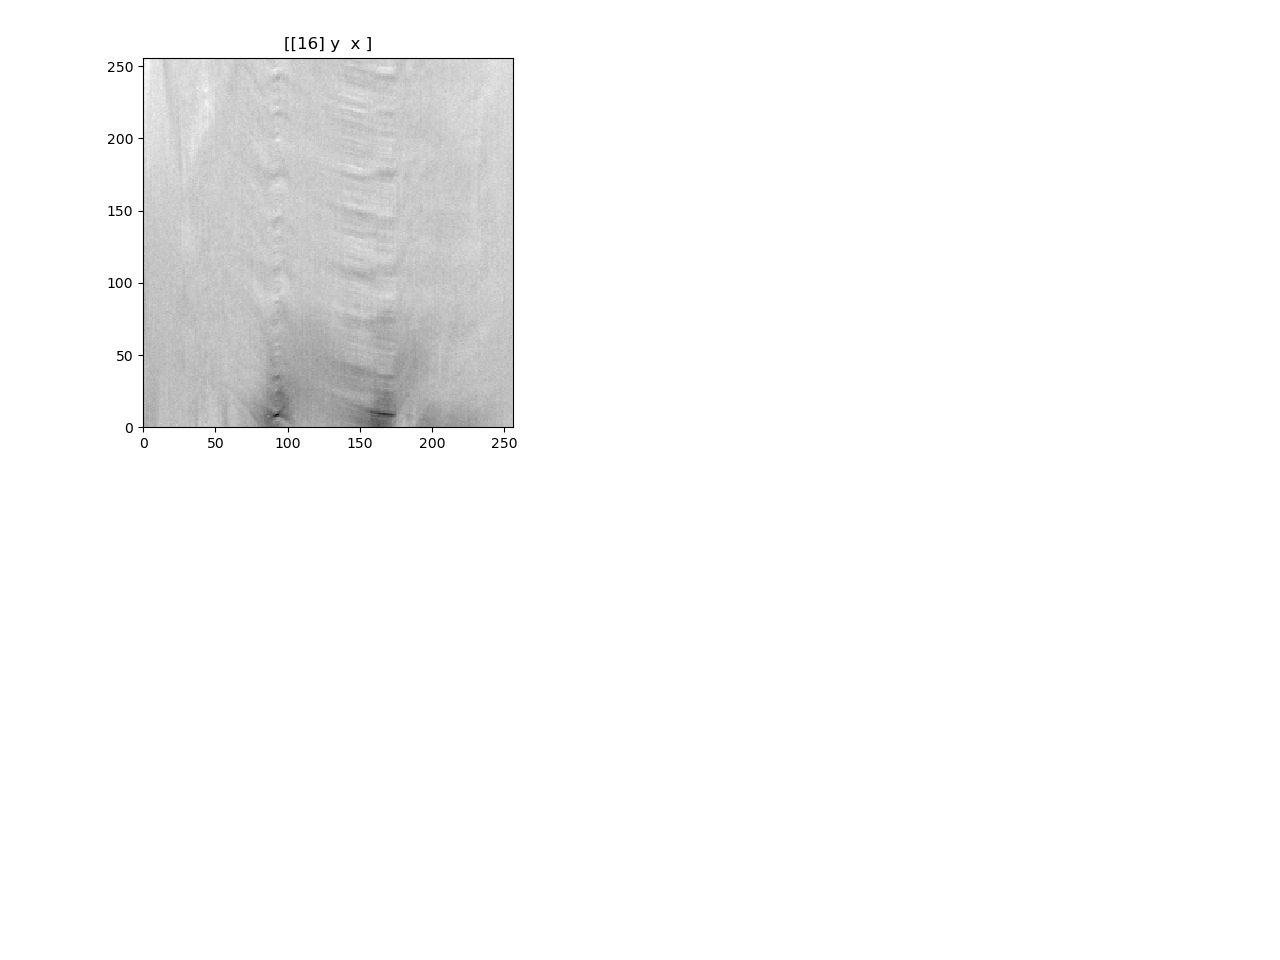

<IPython.core.display.Javascript object>


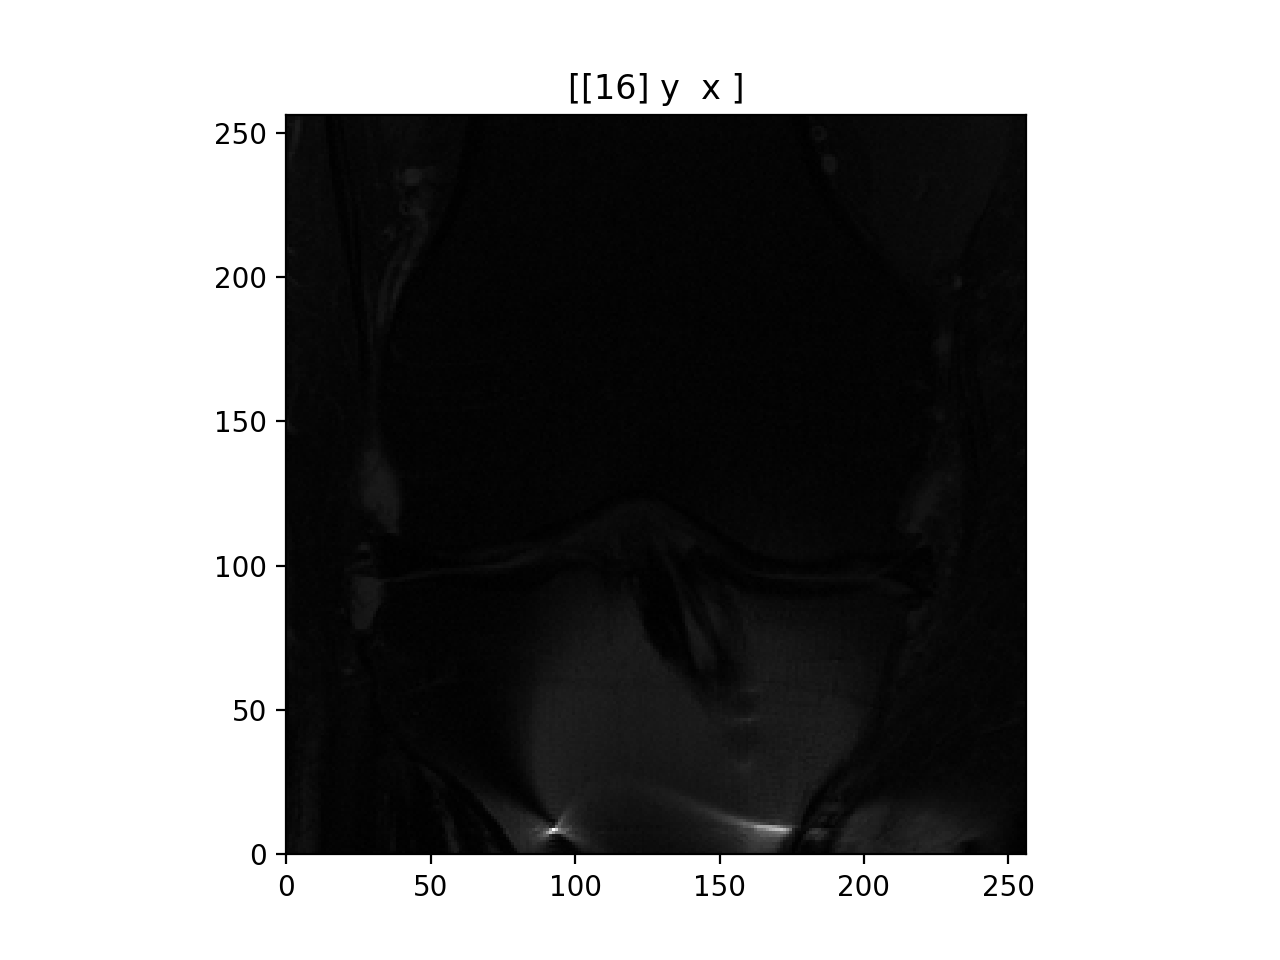

In [22]:
for undersampled_im, fullysampled_im in ds_separated.take(3):
    pl.ImagePlot(undersampled_im[:, :, :, 1]) #this is just real numbers. Don't use this in comparison
    pl.ImagePlot(fullysampled_im[:, :, :, 0])

<IPython.core.display.Javascript object>


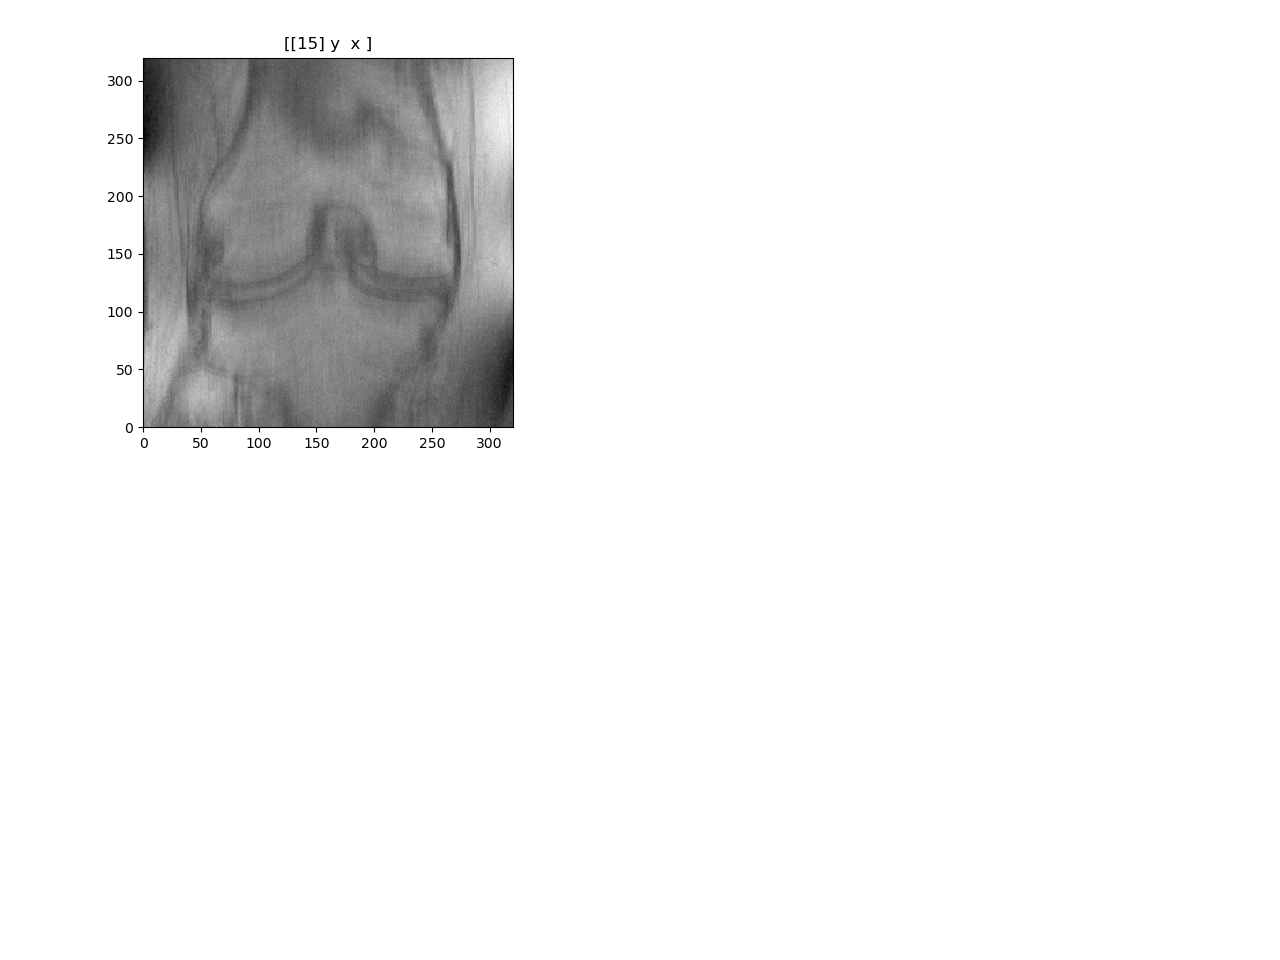

<IPython.core.display.Javascript object>


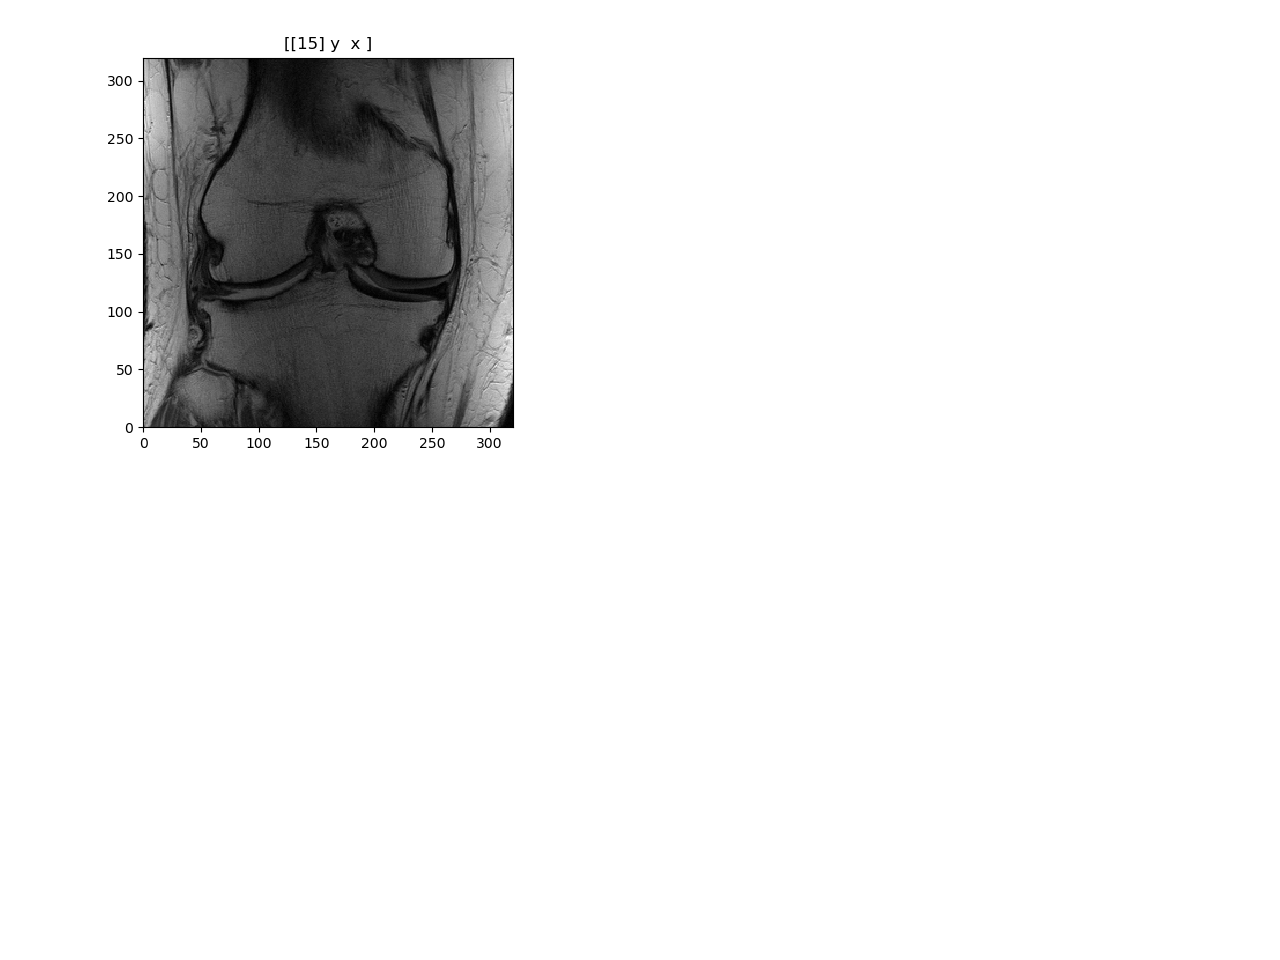

In [6]:
for undersampled_im, fullysampled_im in ds_separated.take(1):
    pl.ImagePlot(undersampled_im[:, :, :, 0]) #this is just real numbers. Don't use this in comparison
    pl.ImagePlot(fullysampled_im[:, :, :, 0])

In [7]:
# this block doesn't separate imaginary and real; for display purposes
def _get_kspace_and_reconstruction_rss(filename):
    """
    @params filename: full path to .h5 mri file
    @return kspace data of that particular file
    """
    try:
        with h5py.File(filename, 'r') as hr:
            return hr['kspace'][:], hr['reconstruction_rss'][:]
    except:
        print(f'Error could not open {filename}')

def _get_kspace_undersampled(kspace, center_fractions = [0.04], accelerations = [4]):
    """
    @params kspace: from _get_kspace_and_reconstruction_rss(filename)
    @params center_fractions: for undersampling, 
        N*center_fraction columns in center corresponding to low-frequencies
    @params accelerations: how much mri acquisition is sped up
    @return undersampled k-space
    """
    mask_func = RandomMaskFunc(
        center_fractions = center_fractions, 
        accelerations = accelerations
    )
    mask = np.array(mask_func(kspace.shape))
    return kspace * mask

def _get_mri_im(
#     kspace, 
    reconstruction_rss,
    kspace_undersampled, 
    DATASET
):
    """
    # @params kspace: from _get_kspace_and_reconstruction_rss(filename)
    @params reconstruction_rss: reconstructed MR image of fully sampled kspace, provided
    @params kspace_undersampled: mask-undersampled k-space from _get_kspace_undersampled
    @params DATASET: i.e. 'singlecoil_challenge' or 'multicoil_challenge'
    @return (undersampled mri image, fully sampled mri image (i.e. label for GAN))
    """
    undersampled_im = sp.ifft(kspace_undersampled, axes=AXES[DATASET])
#     fullysampled_im = sp.ifft(kspace, axes=AXES[DATASET])
    
    #crop to make sure images are all the same size
    undersampled_crop = sp.resize(
        undersampled_im,
        [1, 30, 320, 320]
    )
    
    fullysampled_crop = sp.resize(
        reconstruction_rss,
        [1, 30, 320, 320]
    )
    
    
    return (
        undersampled_crop,
        fullysampled_crop,
    )


    

def get_datum_from_single_file(filename, DATASET):
    """
    user-facing function for tf Dataset object
    @params filename: full path to .h5 mri file
    @params DATASET: i.e. 'singlecoil_challenge' or 'multicoil_challenge'
    @return (undersampled mri image, fully sampled mri image (i.e. label for GAN))
    """
    kspace, reconstruction_rss = _get_kspace_and_reconstruction_rss(filename)
    kspace_undersampled = _get_kspace_undersampled(kspace)
    return _get_mri_im(
        reconstruction_rss,
        kspace_undersampled,
        DATASET,
    )


def get_data_from_files(filenames, DATASET):  
    """
    user-facing function for tf Dataset object
    @params filenames: list of full paths to .h5 mri files
    @params DATASET: i.e. 'singlecoil_train' or 'multicoil_train'
    @return ndarray of 
        (undersampled mri image, fully sampled mri image (i.e. label for GAN))
    """
    undersampled_images = np.ones((1, 30, 320, 320))
    fullysampled_images = np.ones((1, 30, 320, 320))
    for mri_path in filenames:
        try:
            undersampled_crop, fullysampled_crop = get_datum_from_single_file(
                mri_path, DATASET
            )
#             print (undersampled_crop.shape)
#             print (undersampled_images.shape)
            undersampled_images = np.vstack(
                (undersampled_images, undersampled_crop)
            )
            fullysampled_images = np.vstack(
                (fullysampled_images, fullysampled_crop)
            )
        
        except:
            print(f'could not open file {mri_path}')
#             send2trash(mri_path)
            print(f'sent file {mri_path} to trash')
    
    undersampled_images = undersampled_images.reshape(
        (-1, 30, 320, 320, 1)
    )
    
    fullysampled_images = fullysampled_images.reshape(
        (-1, 30, 320, 320, 1)
    )
    

    return undersampled_images[1:], fullysampled_images[1:]



In [8]:
under_sampled, fully_sampled = get_data_from_files(mri_paths, DATASET)
ds = tf.data.Dataset.from_tensor_slices((under_sampled, fully_sampled))
ds = ds.shuffle(150,seed=123,reshuffle_each_iteration=True)

<IPython.core.display.Javascript object>


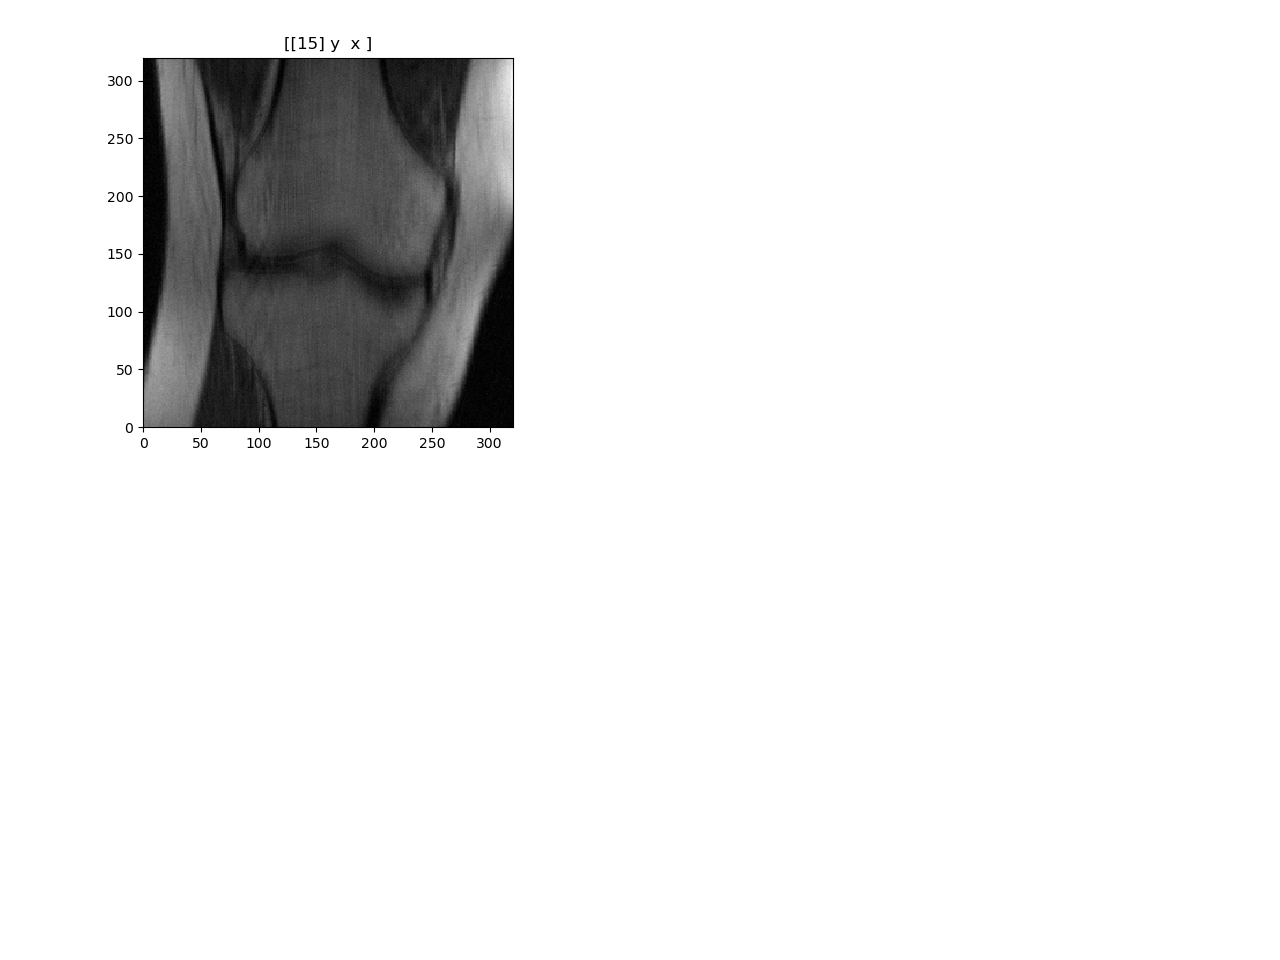

<IPython.core.display.Javascript object>


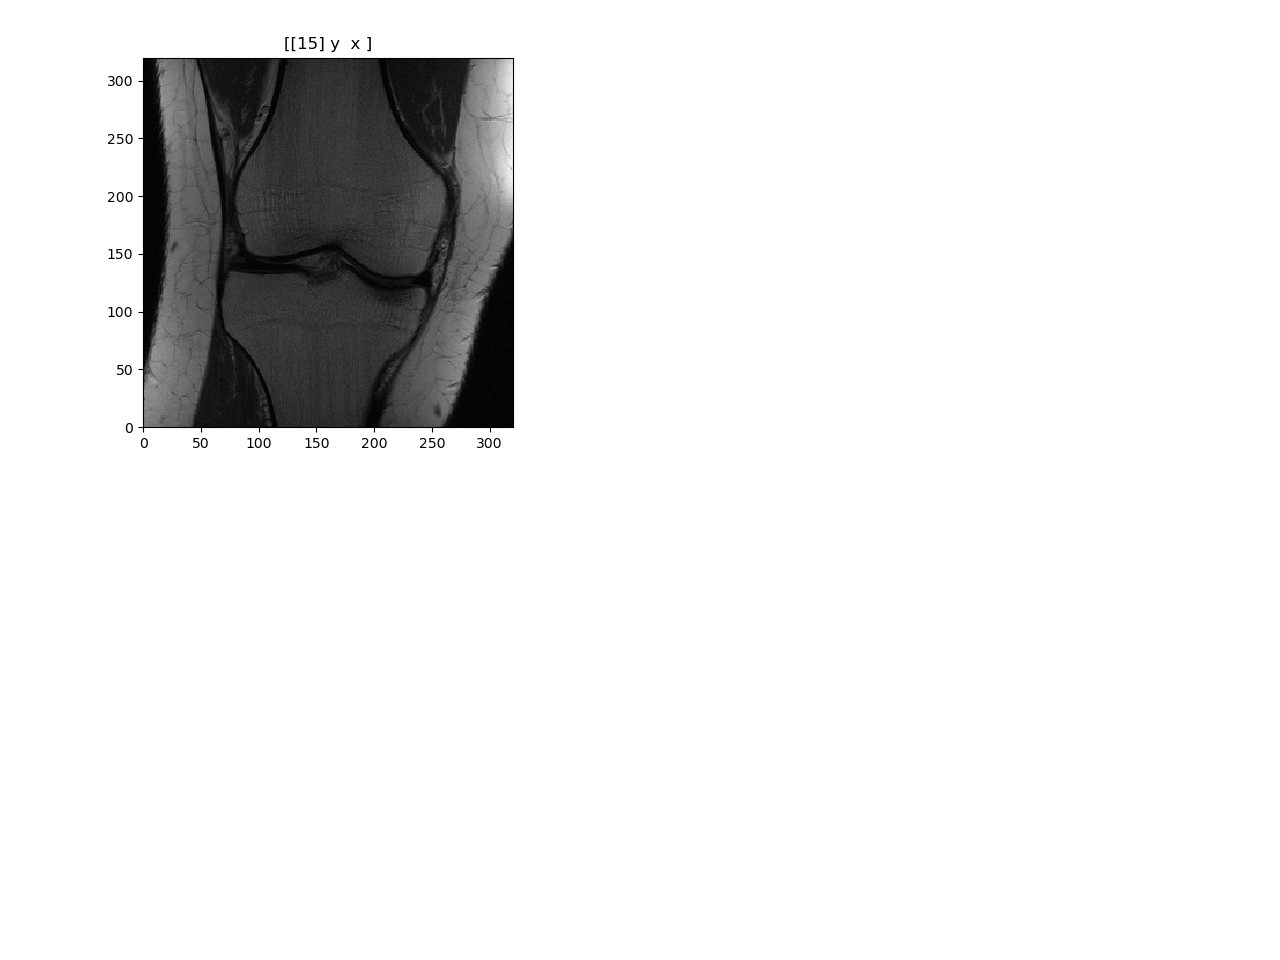

In [9]:
for undersampled_im, fullysampled_im in ds.take(1):
    pl.ImagePlot(undersampled_im[:, :, :, 0])
    pl.ImagePlot(fullysampled_im[:, :, :, 0])
